# Nemours HDF5 Dataset Inference

This notebook performs comprehensive inference on the Nemours HDF5 dataset:

**Tasks:**
1. Run inference on full dataset (all B-scans) and save results
2. Randomly sample 200 images with at least 1 detection and visualize
3. Identify volumes containing both Fovea and SCR classes
4. Generate volume-specific inference results

**Dataset**: `/home/suraj/Data/Nemours/Nemours_Jing_0929.h5`  

**Model**: `checkpoints12022205/best_model.pth`  **Output**: `nemours_inference/`

## 1. Import Libraries and Setup

In [1]:
import h5py
import numpy as np
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.ops as ops
import torch
from tqdm import tqdm

# Import project modules
import sys
sys.path.insert(0, '/home/suraj/Git/RCNN-OCT')
from inference import load_model

# Configuration
HDF5_PATH = Path("/home/suraj/Data/Nemours/Nemours_Jing_0929.h5")
CHECKPOINT_PATH = Path("/home/suraj/Git/RCNN-OCT/checkpoints12022205/best_model.pth")
OUTPUT_DIR = Path("nemours_inference")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SCORE_THRESHOLD = 0.5
RANDOM_SEED = 42

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Score Threshold: {SCORE_THRESHOLD}")

print(f"Device: {DEVICE}")
print(f"Output Directory: {OUTPUT_DIR}")

print(f"HDF5 Dataset: {HDF5_PATH}")
print(f"Model Checkpoint: {CHECKPOINT_PATH}")

Score Threshold: 0.5
Device: cuda
Output Directory: nemours_inference
HDF5 Dataset: /home/suraj/Data/Nemours/Nemours_Jing_0929.h5
Model Checkpoint: /home/suraj/Git/RCNN-OCT/checkpoints12022205/best_model.pth


## 2. Load HDF5 Dataset and Parse Volumes

The HDF5 file contains:
- `images`: (N, 496, 768) uint8 array of OCT B-scans
- `names`: (N,) array of volume identifiers (e.g., "256_L_1_1.e2e")
- `bscan_indices`: (N,) array of B-scan indices within each volume

In [2]:
def load_hdf5_volumes(hdf5_path):
    """Load HDF5 file and organize B-scans by volume."""
    with h5py.File(hdf5_path, 'r') as f:
        images = f['images'][:]
        names = f['names'][:]
        bscan_indices = f['bscan_indices'][:]
    
    # Decode volume names
    names_decoded = [n.decode() if isinstance(n, bytes) else str(n) for n in names]
    
    # Group B-scans by volume
    volumes = defaultdict(list)
    for idx, (name, bscan_idx) in enumerate(zip(names_decoded, bscan_indices)):
        # Remove .e2e extension and use as volume ID
        volume_id = name.replace('.e2e', '')
        volumes[volume_id].append({
            'global_idx': idx,
            'bscan_idx': int(bscan_idx),
            'image': images[idx]
        })
    
    # Sort B-scans within each volume by bscan_idx
    for volume_id in volumes:
        volumes[volume_id].sort(key=lambda x: x['bscan_idx'])
    
    return volumes, images.shape

# Load dataset
print("Loading HDF5 dataset...")
volumes, data_shape = load_hdf5_volumes(HDF5_PATH)

print(f"\n{'='*60}")
print(f"Dataset loaded: {data_shape}")
print(f"Total volumes: {len(volumes)}")
print(f"Total B-scans: {data_shape[0]}")
print(f"Image dimensions: {data_shape[1]} x {data_shape[2]}")
print(f"{'='*60}")

# Display volume statistics
volume_counts = {vol: len(bscans) for vol, bscans in volumes.items()}
sorted_volumes = sorted(volume_counts.items(), key=lambda x: x[1], reverse=True)

print(f"\nTop 10 volumes by B-scan count:")
for i, (vol, count) in enumerate(sorted_volumes[:10], 1):
    print(f"{i:2d}. {vol:25s} - {count:2d} B-scans")

Loading HDF5 dataset...

Dataset loaded: (2540, 496, 768)
Total volumes: 104
Total B-scans: 2540
Image dimensions: 496 x 768

Top 10 volumes by B-scan count:
 1. 142_R_3                   - 31 B-scans
 2. 62_R_6                    - 31 B-scans
 3. 242_L_1                   - 31 B-scans
 4. 25_R_3                    - 31 B-scans
 5. 247_L_1_1                 - 31 B-scans
 6. 62_L_6                    - 31 B-scans
 7. 244_R_1                   - 31 B-scans
 8. 237_R_1                   - 31 B-scans
 9. 257_R_1_1                 - 31 B-scans
10. 72_R_10                   - 31 B-scans


## 3. Load Model

In [3]:
print("Loading model...")
model = load_model(CHECKPOINT_PATH, device=DEVICE)
model.eval()
print("✓ Model loaded successfully!")
model.roi_heads.nms_thresh = 0.3  # default is 0.5
print(f"NMS threshold set to: {model.roi_heads.nms_thresh}")

print("✓ Model loaded successfully!")

Loading model...
✓ Model loaded successfully!
NMS threshold set to: 0.3
✓ Model loaded successfully!


## 4. Task 1: Run Inference on Full Dataset

Run inference on all B-scans in the dataset and save results.

In [4]:
import pickle

def run_inference_on_image(model, image_np, device, score_threshold=0.5):
    """Run inference on a single OCT B-scan image."""
    # Normalize image
    image_np = np.asarray(image_np, dtype=np.float32)
    if image_np.max() > 1.0:
        image_np = image_np / 255.0
    
    # Convert to tensor
    image_tensor = torch.from_numpy(image_np)
    if image_tensor.ndim == 2:
        image_tensor = image_tensor.unsqueeze(0)
    
    # Convert grayscale to RGB (3 channels)
    if image_tensor.shape[0] == 1:
        image_tensor = image_tensor.repeat(3, 1, 1)
    
    # Run inference
    with torch.no_grad():
        outputs = model([image_tensor.to(device)])
    
    output = outputs[0]
    pred_boxes = output["boxes"].cpu().numpy()
    pred_scores = output["scores"].cpu().numpy()
    pred_labels = output["labels"].cpu().numpy()
    
    # Filter by score threshold
    keep = pred_scores >= score_threshold
    pred_boxes = pred_boxes[keep]
    pred_scores = pred_scores[keep]
    pred_labels = pred_labels[keep]
    
    return {
        'image': image_tensor.cpu(),
        'pred_boxes': pred_boxes,
        'pred_scores': pred_scores,
        'pred_labels': pred_labels
    }

# Run inference on ALL B-scans in the entire dataset
all_results = {}  # {volume_id: [results_for_bscans]}

print(f"Running inference on full dataset ({data_shape[0]} B-scans)...")
print(f"Score threshold: {SCORE_THRESHOLD}\n")

for volume_id, bscans in tqdm(volumes.items(), desc="Processing volumes"):
    volume_results = []
    for bscan_info in bscans:
        result = run_inference_on_image(
            model, 
            bscan_info['image'], 
            DEVICE, 
            score_threshold=SCORE_THRESHOLD
        )
        result['bscan_idx'] = bscan_info['bscan_idx']
        result['global_idx'] = bscan_info['global_idx']
        result['volume_id'] = volume_id
        volume_results.append(result)
    
    all_results[volume_id] = volume_results

# Save all results to pickle file
inference_pkl = OUTPUT_DIR / "full_dataset_inference.pkl"
with open(inference_pkl, 'wb') as f:
    pickle.dump(all_results, f)

total_bscans = sum(len(v) for v in all_results.values())
print(f"\n✓ Inference complete for {total_bscans} B-scans across {len(all_results)} volumes")
print(f"✓ Results saved to: {inference_pkl}")

Running inference on full dataset (2540 B-scans)...
Score threshold: 0.5



Processing volumes: 100%|██████████| 104/104 [05:58<00:00,  3.45s/it]



✓ Inference complete for 2540 B-scans across 104 volumes
✓ Results saved to: nemours_inference/full_dataset_inference.pkl


In [4]:
import pickle

# Load pre-computed inference results instead of running inference again
inference_pkl_path = '/home/suraj/Git/RCNN-OCT/nemours_inference/full_dataset_inference.pkl'

with open(inference_pkl_path, 'rb') as f:
    all_results = pickle.load(f)

print(f"✓ Loaded inference results from: {inference_pkl_path}")
print(f"✓ Loaded {len(all_results)} volumes")
total_bscans = sum(len(v) for v in all_results.values())
print(f"✓ Total B-scans: {total_bscans}")

✓ Loaded inference results from: /home/suraj/Git/RCNN-OCT/nemours_inference/full_dataset_inference.pkl
✓ Loaded 104 volumes
✓ Total B-scans: 2540


## 5. Task 2: Sample 200 Images with Detections

Randomly select 200 B-scans that have at least 1 detection and save visualizations.

In [5]:
# Define specific volumes to sample from
target_volumes = [
    '48_R_8', '242_R_1', '124_R_5', '239_R_1', '152_R_3_1',
    '124_L_5', '259_R_1', '30_L_5', '240_R_1', '240_L_1',
    '62_L_6', '22_R_5', '185_R_3', '241_R_2_1', '30_R_5',
    '47_R_6', '47_L_6', '86_L_6', '247_R_1', '62_R_6'
]

print(f"Target volumes: {len(target_volumes)}")
print("Volumes:", ', '.join(target_volumes))

# Collect all B-scans from the specified volumes
sampled_results = []
volumes_found = []
volumes_not_found = []

for volume_id in target_volumes:
    if volume_id in all_results:
        volumes_found.append(volume_id)
        # Add all B-scans from this volume
        for result in all_results[volume_id]:
            sampled_results.append(result)
    else:
        volumes_not_found.append(volume_id)

print(f"\n{'='*60}")
print(f"Volumes found: {len(volumes_found)}/{len(target_volumes)}")
print(f"Total B-scans collected: {len(sampled_results)}")
print(f"{'='*60}")

if volumes_not_found:
    print(f"\n⚠ Warning: {len(volumes_not_found)} volumes not found in dataset:")
    for vol in volumes_not_found:
        print(f"  - {vol}")

# Display breakdown by volume
print(f"\nB-scans per volume:")
for volume_id in volumes_found:
    num_bscans = len(all_results[volume_id])
    print(f"  {volume_id:20s} - {num_bscans:2d} B-scans")

# Create visualization function
def visualize_detection(result, save_path, min_confidence=0.7):
    """Visualize predictions for a single B-scan."""
    label_names = {1: "Fovea", 2: "SCR"}
    label_colors = {1: "green", 2: "red"}
    
    # Get image
    image = result['image']
    if image.dim() == 3 and image.shape[0] == 3:
        image_np = image[0].numpy()
    else:
        image_np = image.squeeze().numpy()
        
     # Filter predictions by confidence threshold
    high_conf_mask = result['pred_scores'] >= min_confidence
    filtered_boxes = result['pred_boxes'][high_conf_mask]
    filtered_scores = result['pred_scores'][high_conf_mask]
    filtered_labels = result['pred_labels'][high_conf_mask]
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    
    # Plot image
    ax.imshow(image_np, cmap="gray")
    title = f"{result['volume_id']} - B-scan {result['bscan_idx']:03d}"
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.axis("off")
    
    # Plot only high-confidence predictions
    for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
        label_int = int(label)
        color = label_colors.get(label_int, "yellow")
        label_text = label_names.get(label_int, f"Class {label_int}")
        
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2.5, edgecolor=color, facecolor="none"
        )
        ax.add_patch(rect)
        
        bbox_props = dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7, edgecolor="none")
        ax.text(
            x1, y1 - 8, f"{label_text}: {score:.2f}", 
            color="white", fontsize=10, weight="bold", 
            bbox=bbox_props, verticalalignment="top"
        )
    
    # Add detection count (only high-confidence detections)
    num_detections = len(filtered_boxes)
    num_fovea = sum(1 for l in filtered_labels if l == 1)
    num_scr = sum(1 for l in filtered_labels if l == 2)
    
    info_text = f"Detections (conf≥{min_confidence}): {num_detections} (Fovea: {num_fovea}, SCR: {num_scr})"
    ax.text(
        0.02, 0.98, info_text,
        transform=ax.transAxes,
        fontsize=11, weight="bold",
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.9)
    )
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.close()

# Save visualizations for sampled B-scans (with detections)
sample_dir = OUTPUT_DIR / f"selected_{len(target_volumes)}_volumes_detections"
sample_dir.mkdir(parents=True, exist_ok=True)

print(f"\nGenerating visualizations for {len(sampled_results)} B-scans...")
for i, result in enumerate(tqdm(sampled_results, desc="Creating visualizations")):
    filename = f"{result['volume_id']}_bscan_{result['bscan_idx']:03d}.png"
    save_path = sample_dir / filename
    visualize_detection(result, save_path)

print(f"\n✓ Visualizations saved to: {sample_dir}")

# Now save raw images from the original HDF5 dataset
import json
from PIL import Image

# Create directory for raw images
raw_sample_dir = OUTPUT_DIR / f"selected_{len(target_volumes)}_volumes_raw_images"
raw_sample_dir.mkdir(parents=True, exist_ok=True)

# Prepare metadata list for JSON
sampled_metadata = []

print(f"\nExtracting raw images from HDF5 dataset...")
with h5py.File(HDF5_PATH, 'r') as f:
    images = f['images'][:]
    names = f['names'][:]
    bscan_indices = f['bscan_indices'][:]
    
    for i, result in enumerate(tqdm(sampled_results, desc="Extracting raw images")):
        volume_id = result['volume_id']
        bscan_idx = result['bscan_idx']
        global_idx = result['global_idx']
        
        # Get the raw image from HDF5
        raw_image = images[global_idx]
        
        # Create filename
        filename = f"{volume_id}_bscan_{bscan_idx:03d}.png"
        save_path = raw_sample_dir / filename
        
        # Save as PNG using PIL (preserves original dimensions and pixel values)
        img_pil = Image.fromarray(raw_image)
        img_pil.save(save_path)
        
        # Store metadata
        metadata_entry = {
            "index": i,
            "filename": filename,
            "volume_id": volume_id,
            "bscan_index": int(bscan_idx),
            "global_index": int(global_idx),
            "image_shape": list(raw_image.shape),
            "num_detections": len(result['pred_boxes']),
            "detection_labels": [int(label) for label in result['pred_labels']],
            "detection_scores": [float(score) for score in result['pred_scores']]
        }
        sampled_metadata.append(metadata_entry)

# Save metadata to JSON
metadata_path = raw_sample_dir / "selected_volumes_metadata.json"
with open(metadata_path, 'w') as json_file:
    json.dump({
        "total_samples": len(sampled_results),
        "num_target_volumes": len(target_volumes),
        "volumes_found": volumes_found,
        "volumes_not_found": volumes_not_found,
        "target_volumes": target_volumes,
        "source_hdf5": str(HDF5_PATH),
        "image_dimensions": f"{data_shape[1]}x{data_shape[2]}",
        "samples": sampled_metadata
    }, json_file, indent=2)

print(f"\n✓ Raw images saved to: {raw_sample_dir}")
print(f"✓ Metadata saved to: {metadata_path}")
print(f"\nRaw images are {data_shape[1]}x{data_shape[2]} pixels from the original HDF5 dataset.")
print(f"Each image is saved as a grayscale PNG with no annotations or borders.")
print(f"\n{'='*60}")
print(f"SUMMARY:")
print(f"  Target volumes: {len(target_volumes)}")
print(f"  Volumes found: {len(volumes_found)}")
print(f"  Total B-scans extracted: {len(sampled_results)}")
print(f"  Output directory: {raw_sample_dir}")
print(f"{'='*60}")

Target volumes: 20
Volumes: 48_R_8, 242_R_1, 124_R_5, 239_R_1, 152_R_3_1, 124_L_5, 259_R_1, 30_L_5, 240_R_1, 240_L_1, 62_L_6, 22_R_5, 185_R_3, 241_R_2_1, 30_R_5, 47_R_6, 47_L_6, 86_L_6, 247_R_1, 62_R_6

Volumes found: 20/20
Total B-scans collected: 620

B-scans per volume:
  48_R_8               - 31 B-scans
  242_R_1              - 31 B-scans
  124_R_5              - 31 B-scans
  239_R_1              - 31 B-scans
  152_R_3_1            - 31 B-scans
  124_L_5              - 31 B-scans
  259_R_1              - 31 B-scans
  30_L_5               - 31 B-scans
  240_R_1              - 31 B-scans
  240_L_1              - 31 B-scans
  62_L_6               - 31 B-scans
  22_R_5               - 31 B-scans
  185_R_3              - 31 B-scans
  241_R_2_1            - 31 B-scans
  30_R_5               - 31 B-scans
  47_R_6               - 31 B-scans
  47_L_6               - 31 B-scans
  86_L_6               - 31 B-scans
  247_R_1              - 31 B-scans
  62_R_6               - 31 B-scans

Gener

Creating visualizations: 100%|██████████| 620/620 [03:19<00:00,  3.10it/s]



✓ Visualizations saved to: nemours_inference/selected_20_volumes_detections

Extracting raw images from HDF5 dataset...


Extracting raw images: 100%|██████████| 620/620 [00:15<00:00, 39.40it/s]


✓ Raw images saved to: nemours_inference/selected_20_volumes_raw_images
✓ Metadata saved to: nemours_inference/selected_20_volumes_raw_images/selected_volumes_metadata.json

Raw images are 496x768 pixels from the original HDF5 dataset.
Each image is saved as a grayscale PNG with no annotations or borders.

SUMMARY:
  Target volumes: 20
  Volumes found: 20
  Total B-scans extracted: 620
  Output directory: nemours_inference/selected_20_volumes_raw_images


## 6. Verify COCO Annotations on HDF5 Images

Load expert-annotated bounding boxes from COCO format and visualize them on the original HDF5 images.

In [8]:
import json
import re
from collections import defaultdict

# Load COCO annotations
COCO_JSON_PATH = Path("/home/suraj/Data/Nemours/result.json")

print("Loading COCO annotations...")
with open(COCO_JSON_PATH, 'r') as f:
    coco_data = json.load(f)

print(f"\n{'='*60}")
print(f"COCO Annotation Summary:")
print(f"{'='*60}")
print(f"Total images: {len(coco_data['images'])}")
print(f"Total annotations: {len(coco_data['annotations'])}")
print(f"Categories: {coco_data['categories']}")
print(f"{'='*60}")

# Parse filenames to extract volume_id and bscan_idx
# Format example: "61f0371b-22_R_5_bscan_022.png" -> volume_id="22_R_5", bscan_idx=22
# The filename has format: {hash}-{volume_id}_bscan_{idx}.png
def parse_filename(filename):
    """Extract volume_id and bscan_idx from COCO filename."""
    # Get just the filename without path
    basename = Path(filename).name
    # Pattern: {hash}-{volume_id}_bscan_{idx}.png
    # Extract everything after the first '-' and before '_bscan_'
    match = re.match(r'[^-]+-(.+)_bscan_(\d+)\.png', basename)
    if match:
        volume_id = match.group(1)
        bscan_idx = int(match.group(2))
        return volume_id, bscan_idx
    return None, None

# Build lookup: image_id -> (volume_id, bscan_idx, width, height)
image_info = {}
for img in coco_data['images']:
    volume_id, bscan_idx = parse_filename(img['file_name'])
    if volume_id and bscan_idx is not None:
        image_info[img['id']] = {
            'volume_id': volume_id,
            'bscan_idx': bscan_idx,
            'width': img['width'],
            'height': img['height']
        }

# Build lookup: (volume_id, bscan_idx) -> list of annotations
annotations_by_image = defaultdict(list)
for ann in coco_data['annotations']:
    if ann['image_id'] in image_info:
        img_info = image_info[ann['image_id']]
        key = (img_info['volume_id'], img_info['bscan_idx'])
        annotations_by_image[key].append(ann)

print(f"\nSuccessfully parsed {len(image_info)} images")
print(f"Images with annotations: {len(annotations_by_image)}")

# Display sample annotations
print(f"\nSample filename parsing:")
if coco_data['images']:
    sample_img = coco_data['images'][0]
    vol_id, bs_idx = parse_filename(sample_img['file_name'])
    print(f"  Original: {sample_img['file_name']}")
    print(f"  Parsed -> volume_id: '{vol_id}', bscan_idx: {bs_idx}")

print(f"\nSample annotation structure:")
if coco_data['annotations']:
    sample = coco_data['annotations'][0]
    print(f"  image_id: {sample['image_id']}")
    print(f"  category_id: {sample['category_id']}")
    print(f"  bbox (x,y,w,h): {sample['bbox']}")
    print(f"  area: {sample['area']}")

# Count annotations per category
category_counts = defaultdict(int)
for ann in coco_data['annotations']:
    category_counts[ann['category_id']] += 1

print(f"\nAnnotations per category:")
for cat in coco_data['categories']:
    count = category_counts.get(cat['id'], 0)
    print(f"  {cat['name']:10s} (id={cat['id']}): {count:4d} annotations")

Loading COCO annotations...

COCO Annotation Summary:
Total images: 621
Total annotations: 612
Categories: [{'id': 0, 'name': 'SCR'}, {'id': 1, 'name': 'fovea'}, {'id': 2, 'name': 'maybe'}]

Successfully parsed 621 images
Images with annotations: 340

Sample filename parsing:
  Original: ../../home/mbtasepta/.local/share/label-studio/media/upload/2/3a0e5b02-22_R_5_bscan_020.png
  Parsed -> volume_id: '22_R_5', bscan_idx: 20

Sample annotation structure:
  image_id: 0
  category_id: 1
  bbox (x,y,w,h): [634.9999999999999, 136.68656387713523, 107.00000000000017, 188.31343612286517]
  area: 20149.537665146607

Annotations per category:
  SCR        (id=0):  309 annotations
  fovea      (id=1):  143 annotations
  maybe      (id=2):  160 annotations



Testing visualization with sample annotations...

22_R_5 B-scan 020: 1 annotation(s)


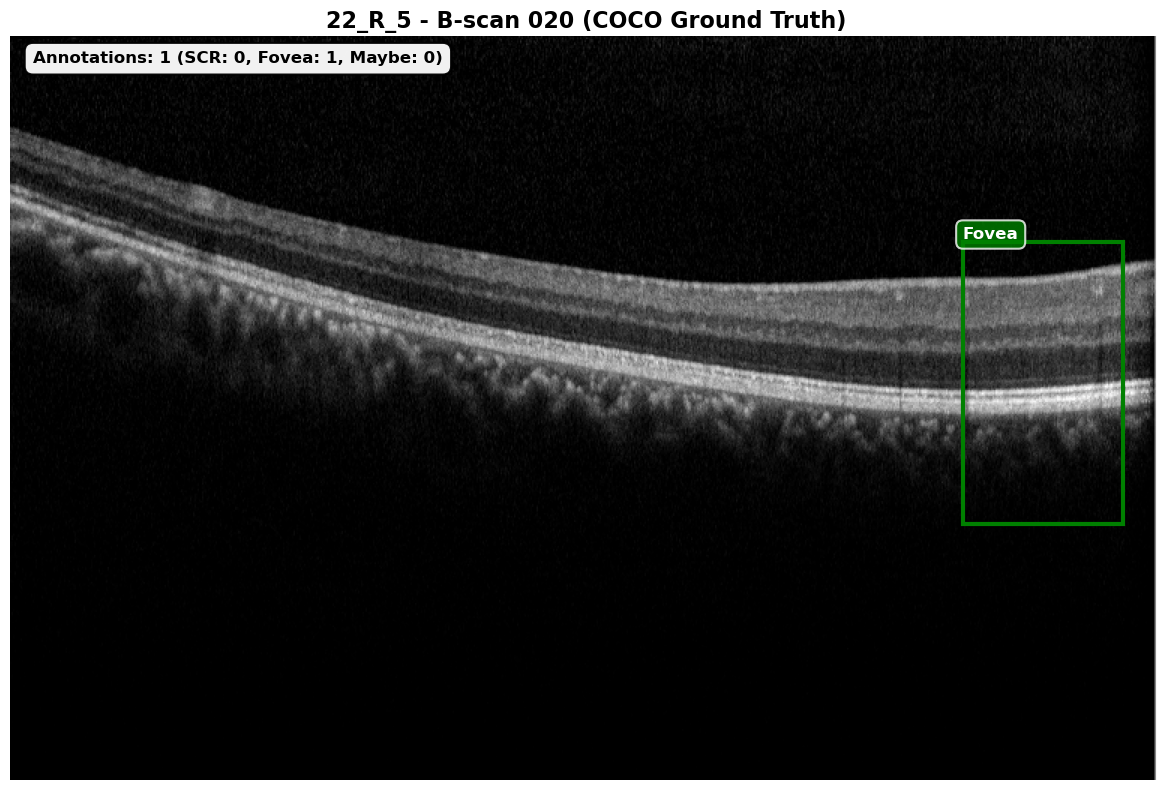


22_R_5 B-scan 023: 1 annotation(s)


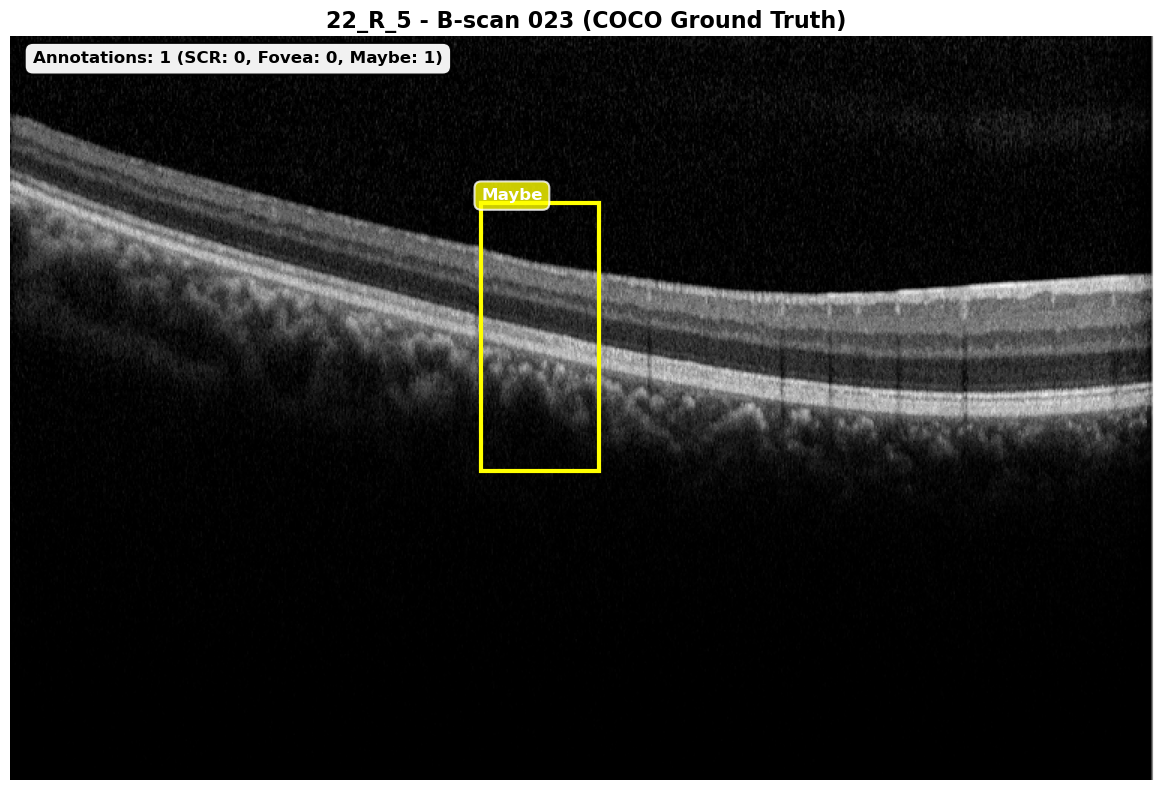


22_R_5 B-scan 024: 1 annotation(s)


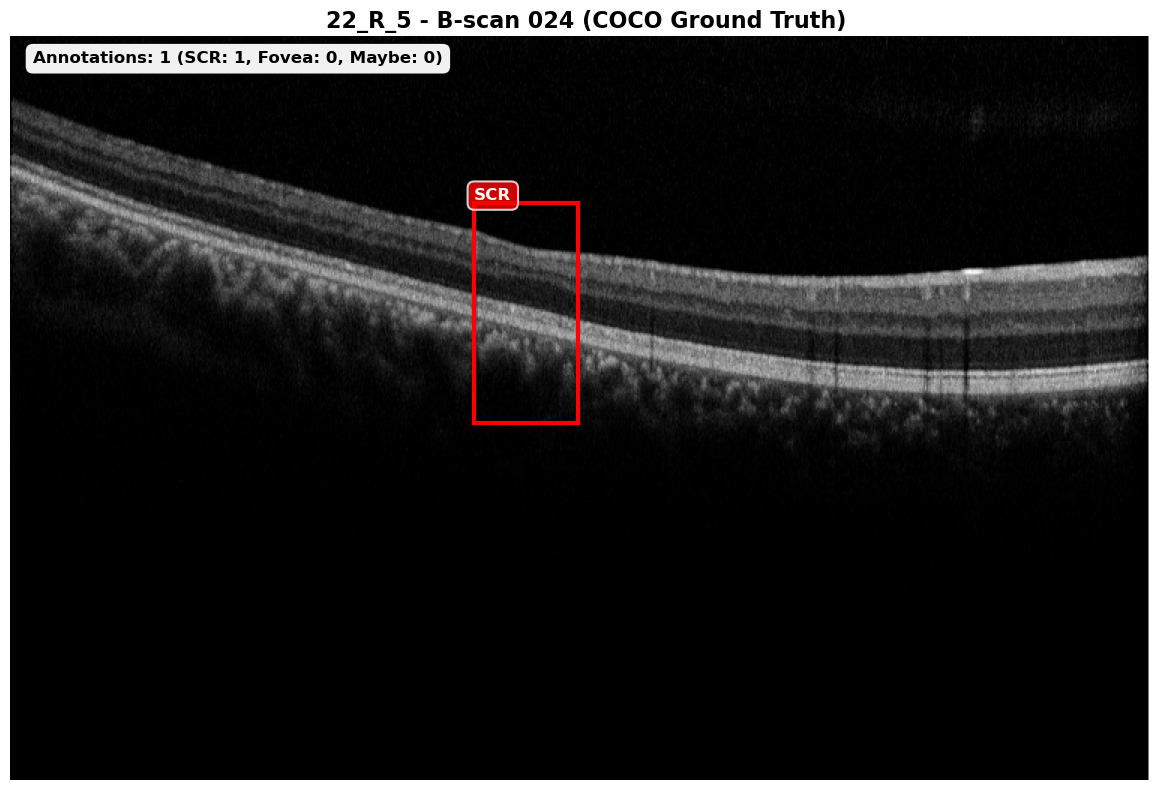

In [9]:
def visualize_coco_annotations(image_np, annotations, volume_id, bscan_idx, save_path=None):
    """
    Visualize COCO format bounding boxes on an OCT B-scan image.
    
    Args:
        image_np: numpy array (H, W) - grayscale image
        annotations: list of COCO annotation dicts with 'bbox' and 'category_id'
        volume_id: str - volume identifier
        bscan_idx: int - B-scan index
        save_path: Path or str - where to save the figure (optional)
    """
    # Category mapping
    category_names = {0: "SCR", 1: "Fovea", 2: "Maybe"}
    category_colors = {0: "red", 1: "green", 2: "yellow"}
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    # Plot image
    ax.imshow(image_np, cmap="gray")
    title = f"{volume_id} - B-scan {bscan_idx:03d} (COCO Ground Truth)"
    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.axis("off")
    
    # Plot annotations
    for ann in annotations:
        # COCO bbox format: [x, y, width, height] where (x,y) is top-left
        x, y, w, h = ann['bbox']
        category_id = ann['category_id']
        
        color = category_colors.get(category_id, "cyan")
        label_text = category_names.get(category_id, f"Class {category_id}")
        
        # Draw rectangle
        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=3, edgecolor=color, facecolor="none", linestyle="-"
        )
        ax.add_patch(rect)
        
        # Add label
        bbox_props = dict(boxstyle="round,pad=0.4", facecolor=color, alpha=0.8, edgecolor="white", linewidth=1.5)
        ax.text(
            x, y - 10, label_text, 
            color="white", fontsize=12, weight="bold", 
            bbox=bbox_props, verticalalignment="top"
        )
    
    # Add annotation count
    num_annotations = len(annotations)
    num_scr = sum(1 for ann in annotations if ann['category_id'] == 0)
    num_fovea = sum(1 for ann in annotations if ann['category_id'] == 1)
    num_maybe = sum(1 for ann in annotations if ann['category_id'] == 2)
    
    info_text = f"Annotations: {num_annotations} (SCR: {num_scr}, Fovea: {num_fovea}, Maybe: {num_maybe})"
    ax.text(
        0.02, 0.98, info_text,
        transform=ax.transAxes,
        fontsize=12, weight="bold",
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.95, edgecolor="black", linewidth=1.5)
    )
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

# Test with a few samples
print("\nTesting visualization with sample annotations...")

# Get a few annotated images
sample_keys = list(annotations_by_image.keys())[:3]

for volume_id, bscan_idx in sample_keys:
    # Find the image in HDF5
    if volume_id in volumes:
        # Find matching B-scan
        matching_bscans = [b for b in volumes[volume_id] if b['bscan_idx'] == bscan_idx]
        if matching_bscans:
            image = matching_bscans[0]['image']
            annotations = annotations_by_image[(volume_id, bscan_idx)]
            
            print(f"\n{volume_id} B-scan {bscan_idx:03d}: {len(annotations)} annotation(s)")
            visualize_coco_annotations(image, annotations, volume_id, bscan_idx)
        else:
            print(f"⚠ B-scan {bscan_idx} not found in volume {volume_id}")
    else:
        print(f"⚠ Volume {volume_id} not found in HDF5 dataset")

### Bonus: Compare COCO Ground Truth vs Model Predictions

Visualize both expert annotations (COCO) and model predictions side-by-side for comparison.

In [10]:
# Generate visualizations for ALL annotated images
coco_viz_dir = OUTPUT_DIR / "coco_annotations_verification"
coco_viz_dir.mkdir(parents=True, exist_ok=True)

print(f"\nGenerating visualizations for all {len(annotations_by_image)} annotated images...")
print(f"Output directory: {coco_viz_dir}\n")

successfully_visualized = 0
not_found = []

for (volume_id, bscan_idx), annotations in tqdm(annotations_by_image.items(), desc="Creating visualizations"):
    # Find the image in HDF5
    if volume_id in volumes:
        # Find matching B-scan
        matching_bscans = [b for b in volumes[volume_id] if b['bscan_idx'] == bscan_idx]
        if matching_bscans:
            image = matching_bscans[0]['image']
            
            # Create filename
            filename = f"{volume_id}_bscan_{bscan_idx:03d}_coco_gt.png"
            save_path = coco_viz_dir / filename
            
            # Visualize and save
            visualize_coco_annotations(image, annotations, volume_id, bscan_idx, save_path)
            successfully_visualized += 1
        else:
            not_found.append(f"{volume_id} B-scan {bscan_idx}")
    else:
        not_found.append(f"{volume_id} (volume not in HDF5)")

print(f"\n{'='*60}")
print(f"Verification Complete!")
print(f"{'='*60}")
print(f"✓ Successfully visualized: {successfully_visualized} images")
print(f"✗ Not found in HDF5: {len(not_found)}")
if not_found and len(not_found) <= 10:
    print(f"\nMissing items:")
    for item in not_found:
        print(f"  - {item}")
elif not_found:
    print(f"\nFirst 10 missing items:")
    for item in not_found[:10]:
        print(f"  - {item}")
print(f"\n✓ Visualizations saved to: {coco_viz_dir}")
print(f"{'='*60}")


Generating visualizations for all 340 annotated images...
Output directory: nemours_inference/coco_annotations_verification



Creating visualizations: 100%|██████████| 340/340 [02:20<00:00,  2.41it/s]


Verification Complete!
✓ Successfully visualized: 340 images
✗ Not found in HDF5: 0

✓ Visualizations saved to: nemours_inference/coco_annotations_verification


In [ ]:
def compare_coco_vs_predictions(image_np, coco_annotations, predictions, volume_id, bscan_idx, save_path=None, min_pred_conf=0.5):
    """
    Side-by-side comparison: COCO ground truth vs model predictions.
    
    Args:
        image_np: numpy array (H, W) - grayscale image
        coco_annotations: list of COCO annotation dicts
        predictions: dict with 'pred_boxes', 'pred_scores', 'pred_labels'
        volume_id: str - volume identifier
        bscan_idx: int - B-scan index
        save_path: Path or str - where to save (optional)
        min_pred_conf: float - minimum confidence for predictions
    """
    # Category mappings
    category_names = {0: "SCR", 1: "Fovea", 2: "Maybe"}
    category_colors = {0: "red", 1: "green", 2: "yellow"}
    pred_label_names = {1: "Fovea", 2: "SCR"}  # Model uses 1=Fovea, 2=SCR
    
    fig, axes = plt.subplots(1, 2, figsize=(24, 8))
    
    # LEFT: COCO Ground Truth
    ax = axes[0]
    ax.imshow(image_np, cmap="gray")
    ax.set_title(f"{volume_id} - B-scan {bscan_idx:03d}\nCOCO Ground Truth", fontsize=14, fontweight="bold")
    ax.axis("off")
    
    for ann in coco_annotations:
        x, y, w, h = ann['bbox']
        category_id = ann['category_id']
        color = category_colors.get(category_id, "cyan")
        label_text = category_names.get(category_id, f"Class {category_id}")
        
        rect = patches.Rectangle((x, y), w, h, linewidth=2.5, edgecolor=color, facecolor="none")
        ax.add_patch(rect)
        bbox_props = dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8, edgecolor="white", linewidth=1)
        ax.text(x, y - 8, label_text, color="white", fontsize=11, weight="bold", 
                bbox=bbox_props, verticalalignment="top")
    
    num_gt = len(coco_annotations)
    ax.text(0.02, 0.98, f"Ground Truth: {num_gt} boxes", transform=ax.transAxes, fontsize=11, weight="bold",
            verticalalignment="top", bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.9))
    
    # RIGHT: Model Predictions
    ax = axes[1]
    ax.imshow(image_np, cmap="gray")
    ax.set_title(f"{volume_id} - B-scan {bscan_idx:03d}\nModel Predictions (conf≥{min_pred_conf})", 
                 fontsize=14, fontweight="bold")
    ax.axis("off")
    
    # Filter predictions by confidence
    high_conf_mask = predictions['pred_scores'] >= min_pred_conf
    filtered_boxes = predictions['pred_boxes'][high_conf_mask]
    filtered_scores = predictions['pred_scores'][high_conf_mask]
    filtered_labels = predictions['pred_labels'][high_conf_mask]
    
    for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
        label_int = int(label)
        # Map model labels to COCO colors (model: 1=Fovea→green, 2=SCR→red)
        color = "green" if label_int == 1 else "red" if label_int == 2 else "yellow"
        label_text = pred_label_names.get(label_int, f"Class {label_int}")
        
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2.5, edgecolor=color, facecolor="none")
        ax.add_patch(rect)
        bbox_props = dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8, edgecolor="white", linewidth=1)
        ax.text(x1, y1 - 8, f"{label_text}: {score:.2f}", color="white", fontsize=11, weight="bold",
                bbox=bbox_props, verticalalignment="top")
    
    num_pred = len(filtered_boxes)
    ax.text(0.02, 0.98, f"Predictions: {num_pred} boxes", transform=ax.transAxes, fontsize=11, weight="bold",
            verticalalignment="top", bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.9))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

# Generate comparison visualizations for annotated images
comparison_dir = OUTPUT_DIR / "coco_vs_predictions_comparison"
comparison_dir.mkdir(parents=True, exist_ok=True)

print(f"\nGenerating COCO vs Predictions comparisons...")
print(f"Output directory: {comparison_dir}\n")

comparison_count = 0
missing_predictions = []

for (volume_id, bscan_idx), coco_annotations in tqdm(annotations_by_image.items(), desc="Creating comparisons"):
    # Check if we have predictions for this image
    if volume_id in all_results:
        matching_predictions = [r for r in all_results[volume_id] if r['bscan_idx'] == bscan_idx]
        
        if matching_predictions and volume_id in volumes:
            prediction = matching_predictions[0]
            
            # Get the image
            matching_bscans = [b for b in volumes[volume_id] if b['bscan_idx'] == bscan_idx]
            if matching_bscans:
                image = matching_bscans[0]['image']
                
                # Create filename
                filename = f"{volume_id}_bscan_{bscan_idx:03d}_comparison.png"
                save_path = comparison_dir / filename
                
                # Generate comparison
                compare_coco_vs_predictions(image, coco_annotations, prediction, volume_id, bscan_idx, save_path)
                comparison_count += 1
            else:
                missing_predictions.append(f"{volume_id} B-scan {bscan_idx} (image not found)")
        else:
            missing_predictions.append(f"{volume_id} B-scan {bscan_idx}")
    else:
        missing_predictions.append(f"{volume_id} (no predictions)")

print(f"\n{'='*60}")
print(f"Comparison Complete!")
print(f"{'='*60}")
print(f"✓ Generated comparisons: {comparison_count}")
print(f"✗ Missing predictions: {len(missing_predictions)}")
if missing_predictions and len(missing_predictions) <= 10:
    print(f"\nMissing predictions for:")
    for item in missing_predictions:
        print(f"  - {item}")
print(f"\n✓ Comparisons saved to: {comparison_dir}")
print(f"{'='*60}")